In [1]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, Callback
from IPython.display import clear_output

In [2]:
X_path = "dataset/data/"
y_path = "dataset/groundtruth/"

X = np.zeros((60, 512, 512, 3))
y = np.zeros((60, 256, 256, 1))

In [3]:
index = 0
for i in tqdm(range(142)):
    try:
        origin = cv2.resize(cv2.imread(X_path+f"{i+1:04d}.jpg"), (512, 512)) / 255
        target = np.expand_dims(cv2.resize(cv2.imread(y_path+f"{i+1:04d}_gt.pgm", cv2.IMREAD_GRAYSCALE), (256, 256)), axis=-1) / 255
    except:
        continue
        
    X[index] = origin
    y[index] = target
    index += 1

print(index, "Images")

100%|██████████| 142/142 [00:00<00:00, 185.64it/s]

60 Images


In [4]:
class PlotLearning(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []
        

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
        clear_output(wait=True)
        
        ax1.set_yscale('Log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show();
        
        
plot = PlotLearning()
e_stopping = EarlyStopping(patience=5, verbose=1)

In [11]:
model = Sequential([
    Conv2D(16, (3, 3), input_shape=(512, 512, 3), padding="same", kernel_regularizer='l2'),
    Conv2D(16, (3, 3), padding="same", kernel_regularizer='l2'),
    Conv2D(16, (3, 3), padding="same", kernel_regularizer='l2'),
    Conv2D(16, (3, 3), padding="same", kernel_regularizer='l2'),
    
    MaxPool2D((2,2)),
    
    Conv2D(32, (3, 3), padding="same", kernel_regularizer='l2'),
    Conv2D(32, (3, 3), padding="same", kernel_regularizer='l2'),
    Conv2D(32, (3, 3), padding="same", kernel_regularizer='l2'),
    Conv2D(32, (3, 3), padding="same", kernel_regularizer='l2'),
    
    Conv2D(1, (3, 3), padding="same", kernel_regularizer='l2'),
])

model.summary()
model.compile(
    optimizer='Adam',
    loss="mse",
    metrics=['acc']
)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 512, 512, 16)      448       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 512, 512, 16)      2320      
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 512, 512, 16)      2320      
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 512, 512, 16)      2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 256, 256, 16)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 256, 256, 32)      4640      
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 256, 256, 32)     

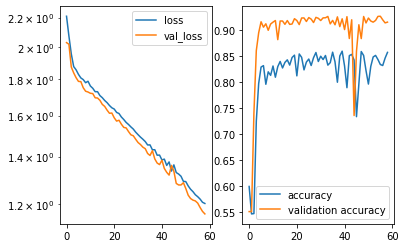

32/50 [==================>...........] - ETA: 12s

KeyboardInterrupt: 

In [12]:
model.fit(X[:-10], y[:-10], epochs=100, callbacks=[plot, e_stopping], validation_data=(X[-10:], y[-10:]))

In [27]:
#tf.saved_model.save(model, "model_dir/1/")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model_dir/1/assets


In [28]:
#model.save("model_dir/model.h5")

In [25]:
model = load_model("model_dir/model.h5")

def get_masked_image(img, k=5, erode_iter=2):
    """
    k: de-noising factor
    """
    masked_img = model.predict(np.array([img]))[0].T[0].T
    print("Darkening Non Sky Pixel!")
    plt.imshow(masked_img, cmap='gray')
    plt.show()
    
    blurred = cv2.GaussianBlur(masked_img, (11, 11), 0) ** k
    print("Blurring Image")
    plt.imshow(blurred, cmap='gray')
    plt.show()
    
    thresh = cv2.threshold(blurred*255, 50, 52, cv2.THRESH_BINARY)[1]
    print("Thresholding Image")
    plt.imshow(thresh, cmap='gray')
    plt.show()
    # perform a series of erosions and dilations to remove
    # any small blobs of noise from the thresholded image
    thresh = cv2.erode(thresh, None, iterations=erode_iter)
    print("Eroding Image")
    plt.imshow(thresh, cmap='gray')
    plt.show()
    
    """thresh = cv2.dilate(thresh, None, iterations=4)
    print("Dilating Image")
    plt.imshow(thresh, cmap='gray')
    plt.show()"""
    
    return thresh

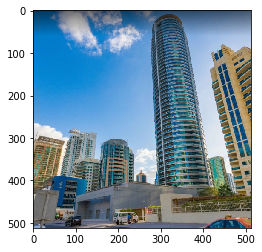

Darkening Non Sky Pixel!


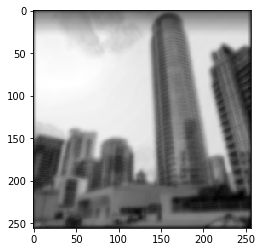

Blurring Image


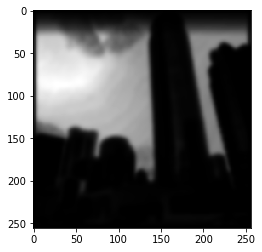

Thresholding Image


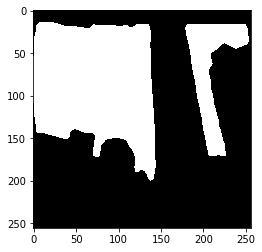

Eroding Image


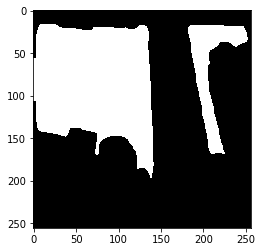

Final Image


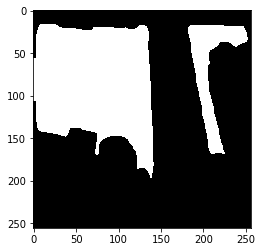

In [28]:
img = cv2.resize(cv2.imread("test_images/building.png"), (512, 512)) / 255
plt.imshow(img.T[::-1].T)
plt.show()

masked_img = get_masked_image(img)
print("Final Image")
plt.imshow(masked_img, cmap='gray')
plt.show()

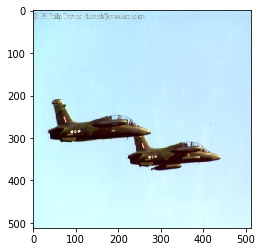

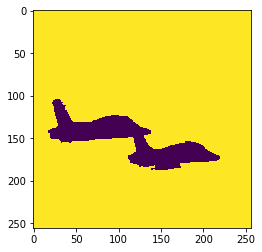

In [36]:
plt.imshow(X[0]/255)
plt.show()
plt.imshow(y[0].T[0].T)
plt.show()